In [1]:
!date

Thu Oct 22 17:42:01 PDT 2020


# Make 10x gene matrix and perform cluster comparison

In [1]:
import anndata
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as scanp
from scipy.stats import ks_2samp, ttest_ind
from scipy import stats
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from matplotlib import cm

import sys
sys.path.append('/home/sina/projects/mop/BYVSTZP_2020/trackfig')
from trackfig.utils import get_notebook_name
from trackfig.trackfig import trackfig 

TRACKFIG = "/home/sina/projects/mop/BYVSTZP_2020/trackfig.txt"
NB = get_notebook_name()

import warnings
warnings.filterwarnings('ignore')

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [2]:
cluster_cmap = {
"Astro": (0.38823529411764707, 0.4745098039215686,  0.2235294117647059 ),  # 637939,
"Endo" : (0.5490196078431373,  0.6352941176470588,  0.3215686274509804 ),  # 8ca252,
"SMC"  : (0.7098039215686275,  0.8117647058823529,  0.4196078431372549 ),  # b5cf6b,
"VLMC" : (0.807843137254902,   0.8588235294117647,  0.611764705882353  ),  # cedb9c,
"Low Quality" : (0,0,0),
"L2/3 IT" : (0.9921568627450981,  0.6823529411764706,  0.4196078431372549  ),  # fdae6b
"L5 PT" : (0.9921568627450981,  0.8156862745098039,  0.6352941176470588  ),  # fdd0a2
"L5 IT" : (0.5176470588235295,  0.23529411764705882, 0.2235294117647059 ),  # 843c39
"L5/6 NP": "#D43F3A",
"L6 CT" : (0.8392156862745098,  0.3803921568627451,  0.4196078431372549 ),  # d6616b
"L6 IT" : (0.9058823529411765,  0.5882352941176471,  0.611764705882353  ),  # e7969c
"L6b" : (1.0,                 0.4980392156862745,  0.054901960784313725),  # ff7f0e
"L6 IT Car3" : (1.0,                 0.7333333333333333,  0.47058823529411764 ),  # ffbb78
"Lamp5" : (0.19215686274509805, 0.5098039215686274,  0.7411764705882353  ),  # 3182bd # blues
"Sncg" : (0.4196078431372549,  0.6823529411764706,  0.8392156862745098  ),  # 6baed6
"Vip" : (0.6196078431372549,  0.792156862745098,   0.8823529411764706  ),  # 9ecae1
"Sst" : (0.7764705882352941,  0.8588235294117647,  0.9372549019607843  ),  # c6dbef
"Pvalb":(0.7372549019607844,  0.7411764705882353,  0.8627450980392157  ),  # bcbddc
}

In [3]:
adata = anndata.read_h5ad("../../data/notebook/revision/10xv3_gene.h5ad")

In [4]:
md = pd.read_csv("../../reference/10xv3_cluster_labels/sample_metadata.csv", index_col = 0)

md["sex"] = md["Gender"].apply(lambda x: {"Male": "M", "Female":"F"}.get(x, "X"))
adata.obs["date"] = adata.obs.index.map(md["Amp_Date"])
adata.obs["sex"] = adata.obs.index.map(md["sex"])

In [5]:
md.groupby("Amp_Date")["sex"].value_counts()

Amp_Date    sex
11/29/2018  M      60381
12/7/2018   F      54779
4/26/2019   F      35020
            M      26404
Name: sex, dtype: int64

In [6]:
adata = adata[adata.obs.eval("date == '4/26/2019'").values] # males

In [7]:
adata = adata[adata.obs.eval("subclass_label!='Low Quality'")]
adata = adata[adata.obs.eval("subclass_label!='doublet'")]

In [8]:
adata.obs.sex.value_counts()

M    14381
F    12333
Name: sex, dtype: int64

In [9]:
ss = anndata.read_h5ad("../../data/notebook/revision/no_filter_smartseq_gene.h5ad")
ss = ss[ss.obs.eval("subclass_label!='Low Quality'")]

md = pd.read_csv("../../reference/smart-seq_cluster_labels/sample_metadata.csv", index_col = 0)
ss.obs["sex"] = ss.obs.cell_id.map(md["gender"])

ss.var = ss.var.set_index("gene_name") 

Trying to set attribute `.obs` of view, copying.


In [10]:
ss_idx = ss.var.sort_index().index
ad_idx = adata.var.sort_index().index

In [11]:
ss = ss[:,ss_idx].copy()
adata = adata[:,ad_idx].copy()

In [12]:
tenx = adata[:,adata.var.index.isin(ss.var.index)]

In [13]:
print(ss)
print(tenx)

AnnData object with n_obs × n_vars = 6283 × 31053
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id', 'sex'
    var: 'transcript_id', 'gene_id', 'transcript_name', 'length'
View of AnnData object with n_obs × n_vars = 26714 × 31053
    obs: 'batch', 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'subclass_id', 'class_id', 'date', 'sex'
    var: 'gene_name', 'gene_id', 'gene_short_name'


In [15]:
tenx.var.head()

,gene_name,gene_id,gene_short_name
0610005C13Rik_ENSMUSG00000109644,0610005C13Rik_ENSMUSG00000109644,ENSMUSG00000109644,0610005C13Rik
0610006L08Rik_ENSMUSG00000108652,0610006L08Rik_ENSMUSG00000108652,ENSMUSG00000108652,0610006L08Rik
0610009B22Rik_ENSMUSG00000007777,0610009B22Rik_ENSMUSG00000007777,ENSMUSG00000007777,0610009B22Rik
0610009O20Rik_ENSMUSG00000024442,0610009O20Rik_ENSMUSG00000024442,ENSMUSG00000024442,0610009O20Rik
0610010F05Rik_ENSMUSG00000042208,0610010F05Rik_ENSMUSG00000042208,ENSMUSG00000042208,0610010F05Rik


In [16]:
tenx.obs["subclass_label"].value_counts()

L5 IT         10084
L6 CT          5886
L2/3 IT        3722
L6 IT          1841
L5/6 NP        1136
Vip            1020
Sst             871
Lamp5           699
Pvalb           359
Oligo           253
Sncg            196
L6b             169
Astro           148
Endo             78
OPC              71
Macrophage       69
L5 PT            49
L6 IT Car3       39
VLMC             21
SMC               3
Name: subclass_label, dtype: int64

In [17]:
ss.obs["subclass_label"].value_counts()

L5 IT         1571
L6 CT          904
Vip            659
L6b            571
Pvalb          543
L2/3 IT        483
Sst            427
L6 IT          395
Lamp5          377
L5/6 NP        208
Sncg            84
SMC             21
L5 PT           12
Astro           10
Endo             7
VLMC             6
L6 IT Car3       5
Name: subclass_label, dtype: int64

# Number of cells per subclass

In [18]:
tenx.obs["cell_id"] = tenx.obs.index.values

Trying to set attribute `.obs` of view, copying.


In [19]:
cluster_cmap["doublet"] = (0.4588235294117647,  0.4196078431372549,  0.6941176470588235  )  # 756bb1
cluster_cmap["Macrophage"] =     (0.6196078431372549,  0.6039215686274509,  0.7843137254901961  )  # 9e9ac8
cluster_cmap["OPC"] =     (0.7372549019607844,  0.7411764705882353,  0.8627450980392157  )  # bcbddc
cluster_cmap["Oligo"] =     (0.8549019607843137,  0.8549019607843137,  0.9215686274509803  )  # dadaeb

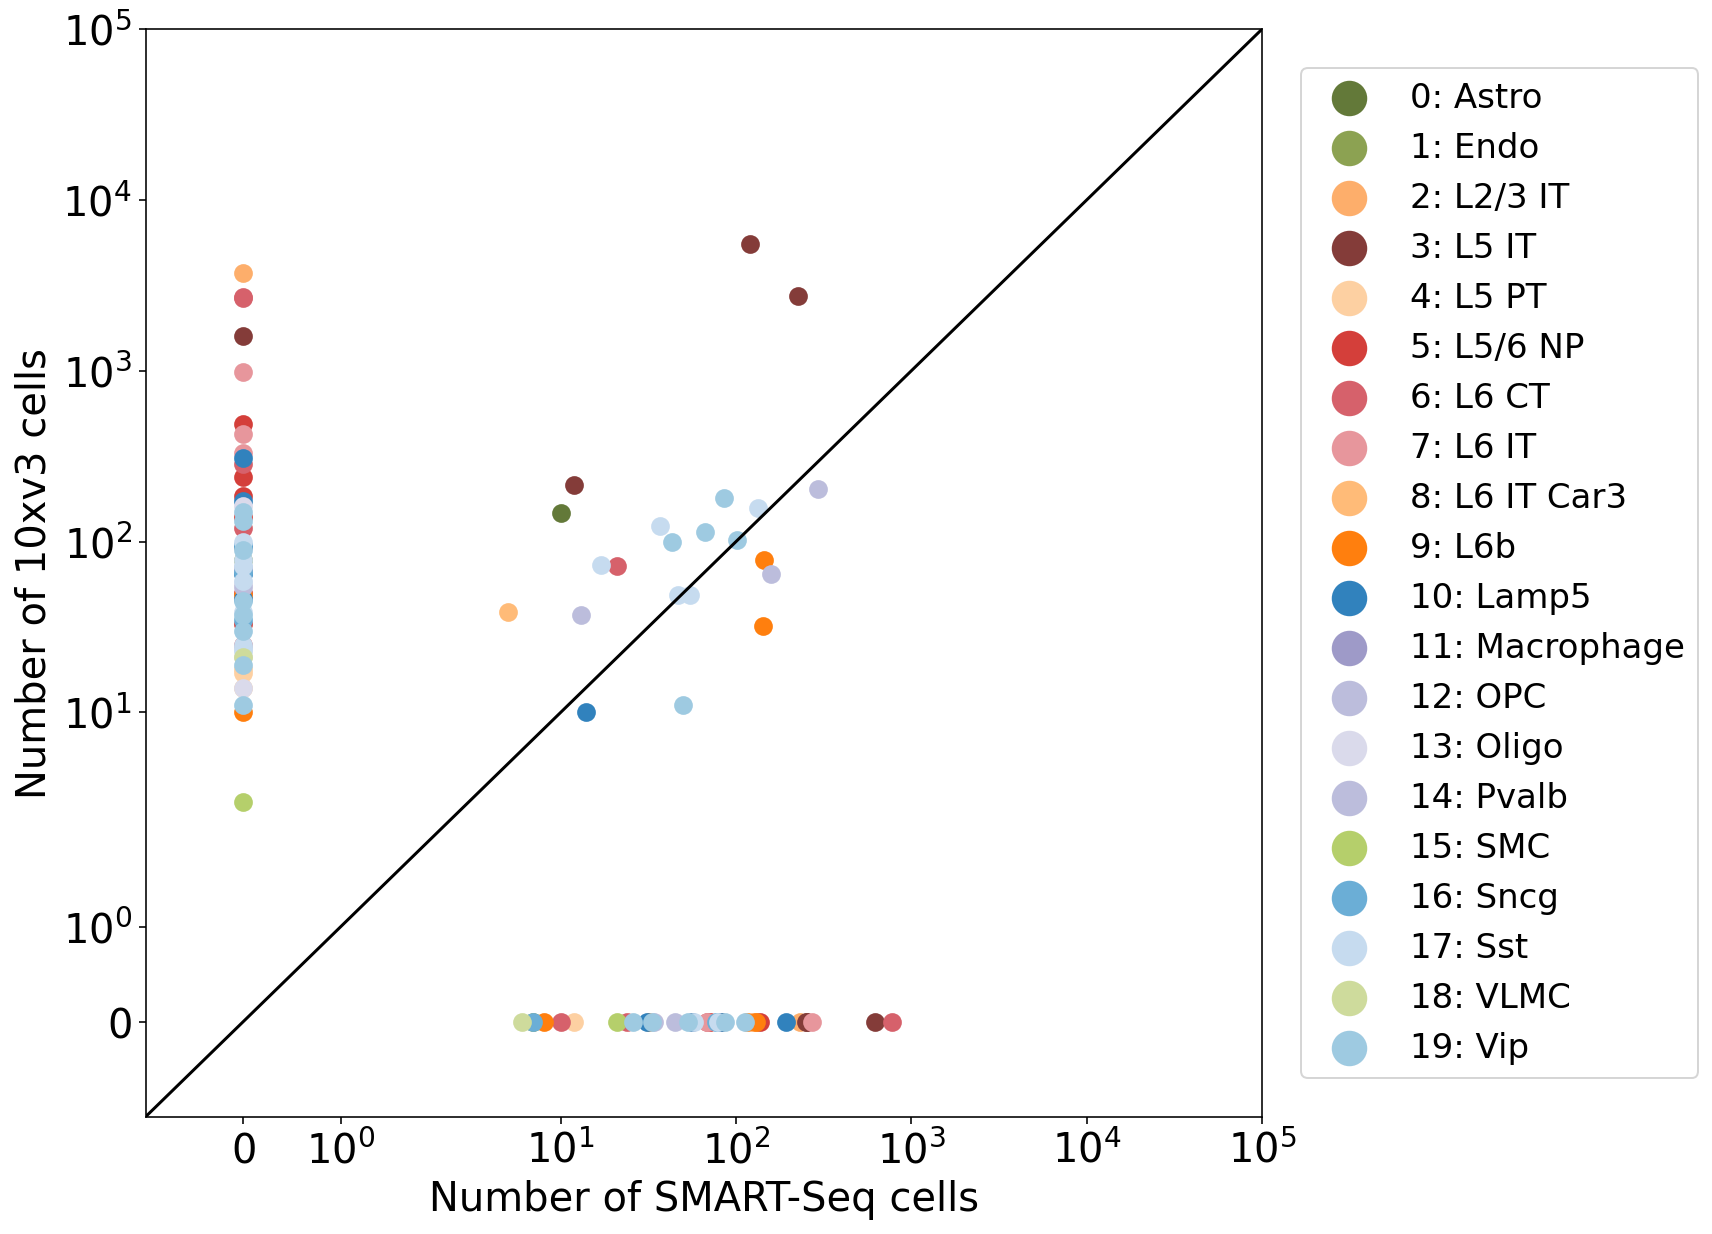

In [21]:
fig, ax = plt.subplots(figsize=(10,10))

ss_labels = ss.obs.groupby("subclass_label").count()["cell_id"].index
tenx_labels = tenx.obs.groupby("subclass_label").count()["cell_id"].index

size=70
for lidx, l in enumerate(tenx_labels):
    if l not in ss_labels:

        y = tenx[tenx.obs["subclass_label"] == l].obs["cluster_label"].value_counts()
        x = np.zeros_like(y)
        
        ax.scatter(x, y, color = cluster_cmap[l], label="{}: {}".format(lidx, l), s=size)
    else: 
            
        x = ss[ss.obs["subclass_label"] == l].obs["cluster_label"].value_counts()
        y = tenx[tenx.obs["subclass_label"] == l].obs["cluster_label"].value_counts()
        union = np.union1d(x.index, y.index)
        
        x_idx = [np.where(union==i)[0][0] for i in x.index]
        y_idx = [np.where(union==i)[0][0] for i in y.index]
        
        xx = np.zeros_like(union)
        xx[x_idx] = x.values
        
        yy = np.zeros_like(union)
        yy[y_idx] = y.values
        
        ax.scatter(xx, yy, color=cluster_cmap[l], label="{}: {}".format(lidx, l), s=size)
        
        
        
ax.plot([-1,10**5], [-1,10**5], color="k")
ax.set_yscale('symlog')
ax.set_xscale('symlog')


ax.set_xlim(-1, 10**5)
ax.set_ylim(-1, 10**5)


ax.legend(loc="center left", bbox_to_anchor=(1.02,0.5), markerscale=2, fontsize=17)

ax.set_xlabel("Number of SMART-Seq cells")
ax.set_ylabel("Number of 10xv3 cells")
plt.savefig(trackfig("../../figures/10x_smartseq_celltypes.png", TRACKFIG, NB), bbox_inches='tight',dpi=300)

plt.show()

In [49]:
import itertools

In [50]:
list(itertools.zip_longest(np.unique(ss.obs.cluster_label).tolist(), np.unique(tenx.obs.cluster_label).tolist()))

[('Astro Aqp4', 'Astro Aqp4'),
 ('Endo Slc38a5', 'Endo Slc38a5_1'),
 ('L2/3 IT Cdh13 Sla', 'L2/3 IT'),
 ('L2/3 IT Macc1', 'L5 ET_1'),
 ('L2/3 IT S100a6', 'L5 ET_2'),
 ('L5 IT Pld5', 'L5 ET_3'),
 ('L5 IT Rspo1', 'L5 IT Pld5'),
 ('L5 IT Rspo2', 'L5 IT S100b'),
 ('L5 IT S100b_1', 'L5 IT Tcap_1'),
 ('L5 IT S100b_2', 'L5 IT Tcap_2'),
 ('L5 IT Tcap_1', 'L5 NP Slc17a8_1'),
 ('L5 IT Tcap_2', 'L5 NP Slc17a8_2'),
 ('L5 NP Slc17a8', 'L5 NP Slc17a8_3'),
 ('L5 PT', 'L6 CT Cpa6_1'),
 ('L6 CT Gpr139', 'L6 CT Cpa6_2'),
 ('L6 CT Grp_1', 'L6 CT Gpr139'),
 ('L6 CT Grp_2', 'L6 CT Nxph2 Kit'),
 ('L6 CT Nxph2_1', 'L6 CT Nxph2 Pou3f2_1'),
 ('L6 CT Nxph2_2', 'L6 CT Nxph2 Pou3f2_2'),
 ('L6 IT Car3', 'L6 IT Car3'),
 ('L6 IT Sulf_1', 'L6 IT Sulf1_1'),
 ('L6 IT Sulf_2', 'L6 IT Sulf1_2'),
 ('L6 IT Sulf_3', 'L6 IT Sulf1_3'),
 ('L6 NP Trh', 'L6 IT Sulf1_4'),
 ('L6b Kcnip1_1', 'L6 NP Trh_1'),
 ('L6b Kcnip1_2', 'L6 NP Trh_2'),
 ('L6b Ror1_1', 'L6 NP Trh_3'),
 ('L6b Ror1_2', 'L6b Kcnip1'),
 ('L6b Rprm', 'L6b Ror1'),
 (

In [22]:
tenx_cluster = np.unique(tenx.obs.cluster_label)
ss_cluster   = np.unique(ss.obs.cluster_label)

union = np.union1d(tenx_cluster, ss_cluster)

In [23]:
x = np.zeros_like(union)
y = np.zeros_like(union)

# Verifying the above is right

## Populate x with cluster values from smart-seq

In [43]:
np.sort(ss.obs.cluster_label.value_counts().index)

array(['Astro Aqp4', 'Endo Slc38a5', 'L2/3 IT Cdh13 Sla', 'L2/3 IT Macc1',
       'L2/3 IT S100a6', 'L5 IT Pld5', 'L5 IT Rspo1', 'L5 IT Rspo2',
       'L5 IT S100b_1', 'L5 IT S100b_2', 'L5 IT Tcap_1', 'L5 IT Tcap_2',
       'L5 NP Slc17a8', 'L5 PT', 'L6 CT Gpr139', 'L6 CT Grp_1',
       'L6 CT Grp_2', 'L6 CT Nxph2_1', 'L6 CT Nxph2_2', 'L6 IT Car3',
       'L6 IT Sulf_1', 'L6 IT Sulf_2', 'L6 IT Sulf_3', 'L6 NP Trh',
       'L6b Kcnip1_1', 'L6b Kcnip1_2', 'L6b Ror1_1', 'L6b Ror1_2',
       'L6b Rprm', 'L6b Shisa6', 'Lamp5 Egln3_1', 'Lamp5 Egln3_2',
       'Lamp5 Lhx6', 'Lamp5 Pdlim5', 'Lamp5 Slc35d3', 'Pvalb Calb1',
       'Pvalb Gpr149', 'Pvalb Reln', 'Pvalb Th', 'Pvalb Vipr2',
       'SMC Aoc3', 'Sncg', 'Sncg Slc17a8', 'Sst C1ql3', 'Sst Chodl',
       'Sst Crhr2_1', 'Sst Crhr2_2', 'Sst Etv1', 'Sst Myh8_1',
       'Sst Myh8_2', 'VLMC', 'Vip C1ql1', 'Vip Chat_1', 'Vip Chat_2',
       'Vip Chat_3', 'Vip Crispld2', 'Vip Gpc3', 'Vip Htr1f',
       'Vip Igfbp6', 'Vip Lmo1', 'Vip Serpinf1'], 

In [40]:
ind = ss.obs.cluster_label.value_counts().index
val = ss.obs.cluster_label.value_counts().values

In [25]:
index = np.array([np.where(union==i)[0][0] for i in ind])
x[index] = val

## Populate y with clusters from 10xv3

In [44]:
np.sort(tenx.obs.cluster_label.value_counts().index)

array(['Astro Aqp4', 'Endo Slc38a5_1', 'L2/3 IT', 'L5 ET_1', 'L5 ET_2',
       'L5 ET_3', 'L5 IT Pld5', 'L5 IT S100b', 'L5 IT Tcap_1',
       'L5 IT Tcap_2', 'L5 NP Slc17a8_1', 'L5 NP Slc17a8_2',
       'L5 NP Slc17a8_3', 'L6 CT Cpa6_1', 'L6 CT Cpa6_2', 'L6 CT Gpr139',
       'L6 CT Nxph2 Kit', 'L6 CT Nxph2 Pou3f2_1', 'L6 CT Nxph2 Pou3f2_2',
       'L6 IT Car3', 'L6 IT Sulf1_1', 'L6 IT Sulf1_2', 'L6 IT Sulf1_3',
       'L6 IT Sulf1_4', 'L6 NP Trh_1', 'L6 NP Trh_2', 'L6 NP Trh_3',
       'L6b Kcnip1', 'L6b Ror1', 'L6b Rprm', 'L6b Shisa6',
       'Lamp5 Egln3_2_1', 'Lamp5 Lhx6', 'Lamp5 Pax6', 'Lamp5 Pdlim5_1',
       'Lamp5 Pdlim5_2', 'Lamp5 Slc35d3_1', 'Macrophage', 'OPC Pdgfra',
       'Oligo Enpp6_1', 'Oligo Enpp6_2', 'Oligo Opalin_1',
       'Oligo Opalin_2', 'Pvalb Calb1', 'Pvalb Gabrg1', 'Pvalb Reln',
       'Pvalb Vipr2', 'SMC', 'Sncg_1', 'Sncg_2', 'Sst C1ql3_1',
       'Sst C1ql3_2', 'Sst Calb2', 'Sst Chodl', 'Sst Crhr2_1',
       'Sst Crhr2_2', 'Sst Hpse_2', 'Sst Hpse_3', 'Sst H

In [26]:
ind = tenx.obs.cluster_label.value_counts().index
val = tenx.obs.cluster_label.value_counts().values

In [27]:
index = np.array([np.where(union==i)[0][0] for i in ind])
y[index] = val

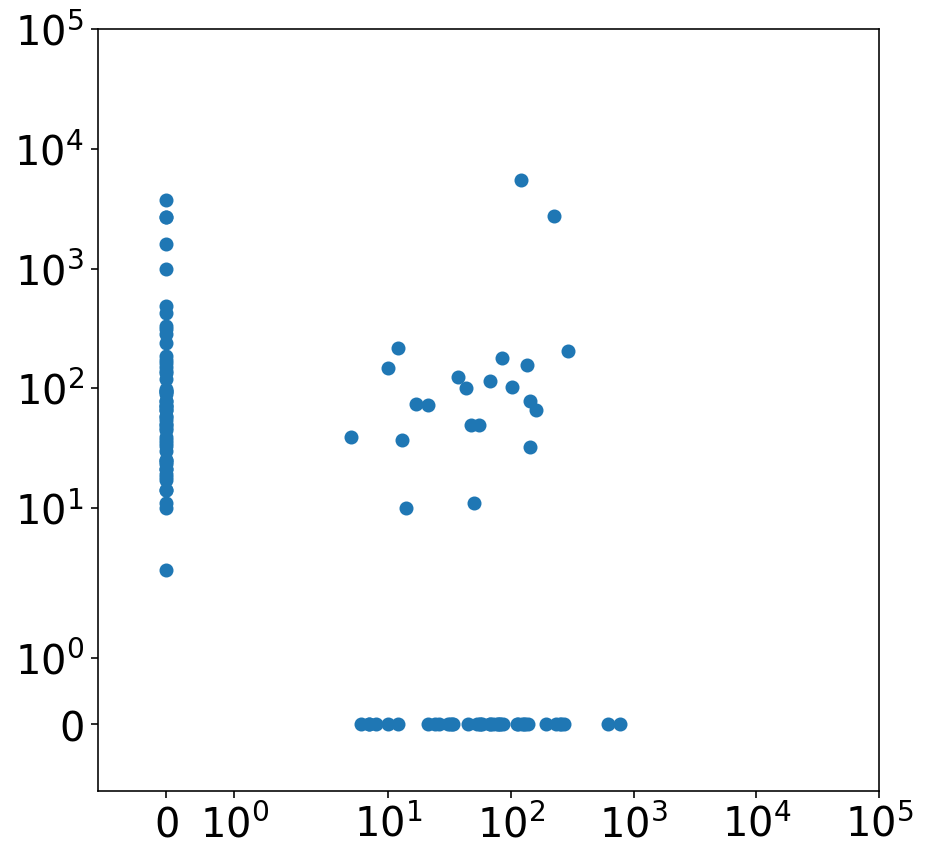

In [28]:
fig, ax = plt.subplots(figsize=(7,7))

ax.scatter(x,y)
ax.set_yscale('symlog')
ax.set_xscale('symlog')


ax.set_xlim(-1, 10**5)
ax.set_ylim(-1, 10**5)
plt.show()

In [29]:
diff = np.setdiff1d(ss.obs.cluster_label, tenx.obs.cluster_label)

In [30]:
diff.shape

(39,)

In [31]:
diff

array(['Endo Slc38a5', 'L2/3 IT Cdh13 Sla', 'L2/3 IT Macc1',
       'L2/3 IT S100a6', 'L5 IT Rspo1', 'L5 IT Rspo2', 'L5 IT S100b_1',
       'L5 IT S100b_2', 'L5 NP Slc17a8', 'L5 PT', 'L6 CT Grp_1',
       'L6 CT Grp_2', 'L6 CT Nxph2_1', 'L6 CT Nxph2_2', 'L6 IT Sulf_1',
       'L6 IT Sulf_2', 'L6 IT Sulf_3', 'L6 NP Trh', 'L6b Kcnip1_1',
       'L6b Kcnip1_2', 'L6b Ror1_1', 'L6b Ror1_2', 'Lamp5 Egln3_1',
       'Lamp5 Egln3_2', 'Lamp5 Pdlim5', 'Lamp5 Slc35d3', 'Pvalb Gpr149',
       'Pvalb Th', 'SMC Aoc3', 'Sncg', 'Sncg Slc17a8', 'Sst C1ql3',
       'Sst Etv1', 'VLMC', 'Vip Chat_1', 'Vip Chat_2', 'Vip Chat_3',
       'Vip Htr1f', 'Vip Lmo1'], dtype=object)

In [32]:
diff = np.setdiff1d(tenx.obs.cluster_label, ss.obs.cluster_label)

In [33]:
diff.shape

(56,)

In [195]:
diff

array(['Endo Slc38a5_1', 'L2/3 IT', 'L5 ET_1', 'L5 ET_2', 'L5 ET_3',
       'L5 IT S100b', 'L5 NP Slc17a8_1', 'L5 NP Slc17a8_2',
       'L5 NP Slc17a8_3', 'L6 CT Cpa6_1', 'L6 CT Cpa6_2',
       'L6 CT Nxph2 Kit', 'L6 CT Nxph2 Pou3f2_1', 'L6 CT Nxph2 Pou3f2_2',
       'L6 IT Sulf1_1', 'L6 IT Sulf1_2', 'L6 IT Sulf1_3', 'L6 IT Sulf1_4',
       'L6 NP Trh_1', 'L6 NP Trh_2', 'L6 NP Trh_3', 'L6b Ror1',
       'Lamp5 Egln3_2_1', 'Lamp5 Pax6', 'Lamp5 Pdlim5_1',
       'Lamp5 Pdlim5_2', 'Lamp5 Slc35d3_1', 'Macrophage', 'OPC Pdgfra',
       'Oligo Enpp6_1', 'Oligo Enpp6_2', 'Oligo Opalin_1',
       'Oligo Opalin_2', 'SMC', 'Sncg_1', 'Sncg_2', 'Sst C1ql3_1',
       'Sst C1ql3_2', 'Sst Calb2', 'Sst Hpse_2', 'Sst Hpse_3',
       'Sst Hspe_1', 'Sst Pvalb Etv1', 'Sst Th', 'VLMC Kcnj8',
       'Vip Cbln4_1', 'Vip Cbln4_2', 'Vip Chat', 'Vip Col14a1',
       'Vip Htr1f_1', 'Vip Htr1f_2', 'Vip Lypd1', 'Vip Mybpc1_1',
       'Vip Mybpc1_2'], dtype=object)

In [196]:
pd.Series(diff).str.split("_").apply(lambda x: x)

0           [Endo Slc38a5, 1]
1                   [L2/3 IT]
2                  [L5 ET, 1]
3                  [L5 ET, 2]
4                  [L5 ET, 3]
5               [L5 IT S100b]
6          [L5 NP Slc17a8, 1]
7          [L5 NP Slc17a8, 2]
8          [L5 NP Slc17a8, 3]
9             [L6 CT Cpa6, 1]
10            [L6 CT Cpa6, 2]
11          [L6 CT Nxph2 Kit]
12    [L6 CT Nxph2 Pou3f2, 1]
13    [L6 CT Nxph2 Pou3f2, 2]
14           [L6 IT Sulf1, 1]
15           [L6 IT Sulf1, 2]
16           [L6 IT Sulf1, 3]
17           [L6 IT Sulf1, 4]
18             [L6 NP Trh, 1]
19             [L6 NP Trh, 2]
20             [L6 NP Trh, 3]
21                 [L6b Ror1]
22        [Lamp5 Egln3, 2, 1]
23               [Lamp5 Pax6]
24          [Lamp5 Pdlim5, 1]
25          [Lamp5 Pdlim5, 2]
26         [Lamp5 Slc35d3, 1]
27               [Macrophage]
28               [OPC Pdgfra]
29           [Oligo Enpp6, 1]
30           [Oligo Enpp6, 2]
31          [Oligo Opalin, 1]
32          [Oligo Opalin, 2]
33        